In [1]:
import logging
import gym
import numpy as np
import os
import matplotlib.pyplot as plt

# add reference libraries here. Current structure will use the relative path from this file
libs = ["NonlinearPendulum.mo"]

# check that all the paths to library package.mo files exist
# DymolaInterface() also checks this but I've found this warning helpful
for lib in libs:
    if not os.path.isfile(lib):
        print(f"Cannot find the library {lib}")

mo_name = "NonlinearPendulum" # name of Modelica model in the Library.Model format
env_entry_point = 'examples:PendulumEnv' # Python package location of RL environment

time_step = 0.5 # time delta in seconds
positive_reward = 1
negative_reward = -100 # penalize RL agent for is_done
log_level = 0
default_action = []

# these config values are passed to the model specific environment class
# mo_name and libs are passed on to the DymolaBaseEnv class
config = {
    'mo_name': mo_name,
    'libs': libs,
    'time_step': time_step,
    'positive_reward': positive_reward,
    'negative_reward': negative_reward,
    'log_level': log_level,
    'default_action': default_action,
    'method':'Dassl'
}

# enable the model specific class as an OpenAI gym environment
from gym.envs.registration import register
env_name = "PedulumEnv-v0"

register(
    id=env_name,
    entry_point=env_entry_point,
    kwargs=config
)

env = gym.make(env_name)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


C:\Users\Aisling\.conda\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


resetting dymola...
dymola has been reset
the model will be reset
the model has been reset
NonlinearPendulum(u1=1.8618171589427346)
NonlinearPendulum(u1=1.2388001988560238)
NonlinearPendulum(u1=1.3776972881363472)
NonlinearPendulum(u1=1.5689868763489203)
NonlinearPendulum(u1=1.9206555005819639)
resetting dymola...
dymola has been reset
the model will be reset
the model has been reset
NonlinearPendulum(u1=1.5)
NonlinearPendulum(u1=1.5)
NonlinearPendulum(u1=1.5)
NonlinearPendulum(u1=1.5)
NonlinearPendulum(u1=1.5)


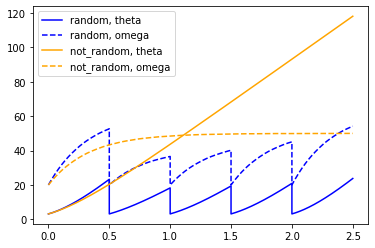

In [2]:
# time is incremented forward but after each step (0.5 seconds) the model seems to be reinitialized

args = ['random','not_random']
colors = ['orange', 'blue']
legend = []
for arg in args:
    # reset the model 
    env.reset_dymola()
    env.reset()
    env.debug_data = {key: [] for key in env.debug_data}
    
    # see what the model outputs
    for timestep in range(5):
        if arg == 'random':
            action = np.random.uniform(1,2)
        else:
            action = 1.5
        env.step([action])
    
    c = colors.pop()
    plt.plot(env.debug_data['my_time'], env.debug_data['theta'], linestyle='-', color=c)
    plt.plot(env.debug_data['my_time'], env.debug_data['omega'], linestyle='--', color=c)
    legend += [f"{arg}, theta", f"{arg}, omega"]
plt.legend(legend)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset
1.413982326931002
1.4791139864532201
1.3769742670524578
1.9706245371557052
1.315400481421992
resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


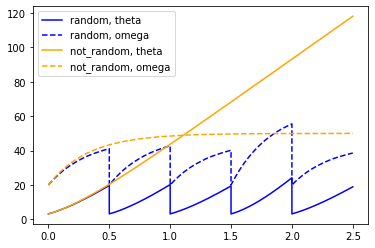

In [3]:
# this block is pretty much identical to the prior one, it just exposes the methods of the DymolaGym class.

import DyMat

args = ['random','not_random']
colors = ['orange', 'blue']
for arg in args:
    # reset the model 
    env.reset_dymola()
    env.reset()
    env.debug_data = {key: [] for key in env.debug_data}
    
    # see what the model outputs
    for timestep in range(5):
        if arg == 'random':
            action = np.random.uniform(1,2)
            print(action)
        else:
            action = 1.5
            
        # the contents of step() without some error handling warnings, etc.
        # step() --> do_simulation()
        env.dymola.importInitial()
        model_with_constructors = env.model_name + f'(u1={action})'
        env.dymola.simulateModel(model_with_constructors, startTime=env.start, stopTime=env.stop)
        env.start += env.tau
        env.stop += env.tau
        
        # step() --> get_state()
        state = []
        data = DyMat.DyMatFile('temp_dir/dsres.mat')
        for name in env.model_output_names:
            state += [data[name][-1]]
            env.debug_data[name] += data[name].tolist()
    
    c = colors.pop()
    plt.plot(env.debug_data['my_time'], env.debug_data['theta'], linestyle='-', color=c)
    plt.plot(env.debug_data['my_time'], env.debug_data['omega'], linestyle='--', color=c)
    legend += [f"{arg}, theta", f"{arg}, omega"]
plt.legend(legend)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset
1.0528084700666565
1.1412776024395463
1.684315012654636
1.1066810875397661
1.1316896409160684
resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


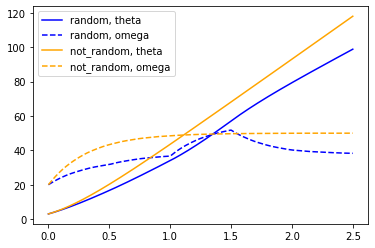

In [4]:
# by initializing each variable in the initial equation section, we get a continuous simulation

args = ['random','not_random']
colors = ['orange', 'blue']
for arg in args:
    # reset the model 
    env.reset_dymola()
    env.reset()
    env.debug_data = {key: [] for key in env.debug_data}
    initial_data = {'omega0':{'name':'omega','value':20}, 'theta0':{'name':'theta','value':3}}
    # see what the model outputs
    for timestep in range(5):
        if arg == 'random':
            action = np.random.uniform(1,2)
            print(action)
        else:
            action = 1.5
            
        # the contents of step() without some error handling warnings, etc.
        # step() --> do_simulation()
        env.dymola.importInitial()
        model_with_constructors = env.model_name + f'(u1={action}'
        for name,v in initial_data.items():
            model_with_constructors += f",{name}={v['value']}"
        model_with_constructors += ')'
        env.dymola.simulateModel(model_with_constructors, startTime=env.start, stopTime=env.stop)
        env.start += env.tau
        env.stop += env.tau
        
        # step() --> get_state()
        state = []
        data = DyMat.DyMatFile('temp_dir/dsres.mat')
        for name in env.model_output_names:
            state += [data[name][-1]]
            env.debug_data[name] += data[name].tolist()
        
        for name,v in initial_data.items():
            v['value'] = data[v['name']][-1]
    c = colors.pop()
    plt.plot(env.debug_data['my_time'], env.debug_data['theta'], linestyle='-', color=c)
    plt.plot(env.debug_data['my_time'], env.debug_data['omega'], linestyle='--', color=c)
    legend += [f"{arg}, theta", f"{arg}, omega"]
plt.legend(legend)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset
1.7365457957746715
1.7171826124942213
1.7476262247311523
1.522984075236236
1.4355134188384342
resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


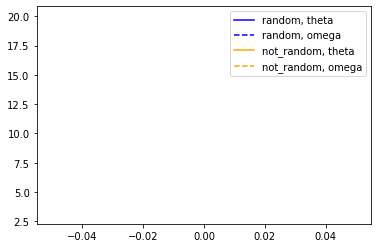

In [16]:
# here's a version that auto assigns ALL the variables in the constructor
args = ['random','not_random']
colors = ['orange', 'blue']
for arg in args:
    # reset the model 
    env.reset_dymola()
    env.reset()
    env.debug_data = {key: [] for key in env.debug_data}
    initial_data = {'omega0':{'name':'omega','value':20}, 'theta0':{'name':'theta','value':3}}
    # see what the model outputs
    for timestep in range(5):
        if arg == 'random':
            action = np.random.uniform(1,2)
            print(action)
        else:
            action = 1.5
            
        # the contents of step() without some error handling warnings, etc.
        # step() --> do_simulation()
        env.dymola.importInitial()
        
        env.action = [np.random.uniform(1,2)]
        action_data = ','.join(f"{k}={v}" for k,v in zip(env.model_input_names, env.action))
        initialization_data = ','.join(f"{k}={data[k][-1]}" for k in data.names() if not k in env.model_input_names)
        model_with_constructors = env.model_name + f'({action_data},{initialization_data})'
        
        env.dymola.simulateModel(model_with_constructors, startTime=env.start, stopTime=env.stop)
        env.start += env.tau
        env.stop += env.tau
        
        # step() --> get_state()
        state = []
        data = DyMat.DyMatFile('temp_dir/dsres.mat')
        for name in env.model_output_names:
            state += [data[name][-1]]
            env.debug_data[name] += data[name].tolist()
        
        for name,v in initial_data.items():
            v['value'] = data[v['name']][-1]
    c = colors.pop()
    plt.plot(env.debug_data['my_time'], env.debug_data['theta'], linestyle='-', color=c)
    plt.plot(env.debug_data['my_time'], env.debug_data['omega'], linestyle='--', color=c)
    legend += [f"{arg}, theta", f"{arg}, omega"]
plt.legend(legend)

In [5]:
env.dymola.close()

0

In [17]:
env.debug_data

{'theta': [3.1415927410125732,
  3.1415927410125732,
  3.1415927410125732,
  3.1415927410125732,
  3.1415927410125732],
 'omega': [20.0, 20.0, 20.0, 20.0, 20.0],
 'my_time': [0.0, 0.0, 0.0, 0.0, 0.0]}